<h1> Blur simulations </h1>
<p> What is the probability distribution over fluorophore locations for the configurations in multiple repeat PAINT? </p>
<p> This notebook takes a few minutes to run, and uses quite a bit of RAM because I wrote the convolution calculation myself, and it's not very efficient... </p>

<h4> Imports, defaults, loading </h4>

In [1]:
import numpy as np
from copy import copy
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.colors as colors
import matplotlib.cm as cmx
from matplotlib import rc
rc('font',**{'family':'serif','sans-serif':['Arial']})
rc('text', usetex=False)

import matplotlib 
matplotlib.rc('xtick', labelsize=8) 
matplotlib.rc('ytick', labelsize=8) 
plt.rcParams.update({'font.size': 8})

def read_file(fname,N_EQUIL=int(1e3)):
    data = (pd.read_csv(fname,sep = '  ',header = None) - 50 ) * 0.85
    r = np.sqrt(data[0]**2 + data[1]**2)
    return np.array(r[N_EQUIL:])

def load_data(dir_name):
    all_data = []
    for primary_index in range(1,6):
        for run_index in range(1,7):
            data = read_file(f'../blur_results/blur_simulations{primary_index}/run.{run_index}/{dir_name}/c.txt')
            all_data.append(copy(data))
    return all_data
        

lat_disp = {}
for run in ['1.0','3.0','3.1','3.2','6.0','6.1','6.2','6.3','6.4','6.5']:
    lat_disp[run] = load_data(run)

/home/wtk23/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


<h4> distributions in 2D </h4>

<p> What I'm plotting below is p(r), where r is the cylindrical coordinate r. So we should expect everything to go through the origin </p> 

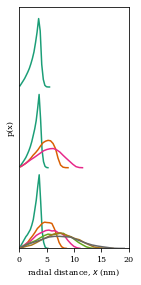

In [2]:
new_lat_disp = {}
for i in lat_disp:
    new_lat_disp[i] = []
    for j in lat_disp[i]:
        new_lat_disp[i] = new_lat_disp[i] + list(j)

lat_disp = new_lat_disp


f,ax = plt.subplots(1,1,figsize = (2,4))

jet = cm = plt.get_cmap('Dark2')    
cNorm = colors.Normalize(vmin=0,vmax=5)
scalarMap = cmx.ScalarMappable(norm=cNorm,cmap=jet)

BINS = 20

OFFSET = 0.7

alpha = 1.0
for index in range(1):
    colorVal = list(scalarMap.to_rgba(index))
    colorVal[-1] = alpha
    a,b,c=plt.hist(lat_disp['1.0'],bins = BINS,color = [0,0,0,0],density = 1)
    b = (b[1:]+b[:-1])/2.
    ax.plot(b,a+2*OFFSET,color=colorVal)

for index in range(3):
    
    colorVal = list(scalarMap.to_rgba(index))
    colorVal[-1] = alpha
    a,b,c=plt.hist(lat_disp['3.%s'%(index,)],bins = BINS,color = [0,0,0,0],density=1) 
    b = (b[1:]+b[:-1])/2.
    ax.plot(b,a+OFFSET,color=colorVal)

for index in range(6):
    
    colorVal = list(scalarMap.to_rgba(index))
    colorVal[-1] = alpha
    a,b,c=plt.hist(lat_disp['6.%s'%(index,)],bins = BINS,color = [0,0,0,0],density=1)
    b = (b[1:]+b[:-1])/2.
    ax.plot(b,a,color=colorVal)

ax.get_yaxis().set_ticks([])

ax.set_ylabel('p(x)')
ax.set_xlabel('radial distance, $x$ (nm)')
ax.set_xlim(0,20)

plt.tight_layout()

plt.savefig('counts_profile.png',dpi = 1000)
plt.savefig('counts_profile.pdf',tight_layout=True)

<h4> How many samples did we end up collecting? </h4>

In [3]:
for i in lat_disp:
    print (i,len(lat_disp[i]))

1.0 335195
3.0 193642
3.1 187089
3.2 206257
6.0 121761
6.1 118252
6.2 117955
6.3 118196
6.4 118508
6.5 126562


In [4]:
#find the length of each of these!

<h4> Now we from p(r), to the local density of points, which is p(r) / r, together with some normalization... </h4>

/home/wtk23/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """


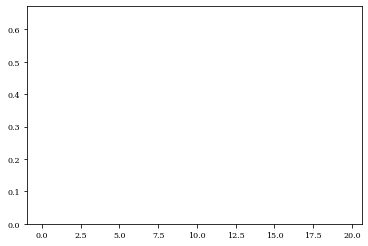

In [5]:
#use rayleigh criterion!
from scipy.interpolate import interp1d
intensity_dict = {}
for key in lat_disp:
    a,b,c=plt.hist(lat_disp[key],bins = BINS,color = [0,0,0,0],normed = 1)
    b = (b[1:] + b[:-1])/2.
    intensity_dict[key] = interp1d(b,a/np.sum(a)/b,kind='linear',bounds_error=False,fill_value=(0,0))

In [6]:
#now I try to make representative spots with this radial density!
simulated_spots = {}

Xmax = 30
Ymax = 30
L = 400

pixels_per_nm = float(L) / float(Xmax)

for key in intensity_dict:
    canvas = np.zeros((L,L)).astype(dtype = float)
    center = [L/2,L/2]

    center = [Xmax/2.,Ymax/2.]
    x_vals = np.linspace(0,Xmax,L)
    y_vals = np.linspace(0,Ymax,L)

    for x_index,x in enumerate(x_vals):
        for y_index,y in enumerate(y_vals):
            dist = np.sqrt((x-center[0])**2 + (y-center[1])**2)
            intensity = intensity_dict[key](dist)
            canvas[x_index][y_index] = intensity
    simulated_spots[key] = np.copy(canvas)

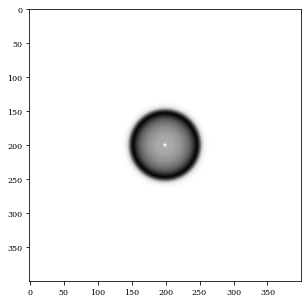

In [7]:
f,ax = plt.subplots(1,1,figsize = (5,5))
ax.imshow(simulated_spots['1.0'],cmap = 'Greys', interpolation = 'bicubic')

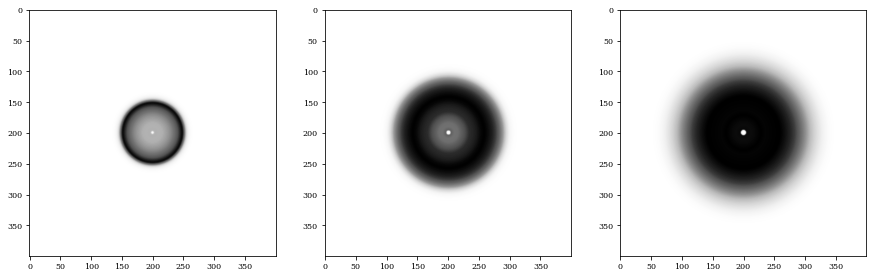

In [41]:
f,ax = plt.subplots(1,3,figsize = (15,5))
for a,loc in zip(ax,['3.0','3.1','3.2']):
    a.imshow(simulated_spots[loc],cmap = 'Greys', interpolation = 'bicubic')

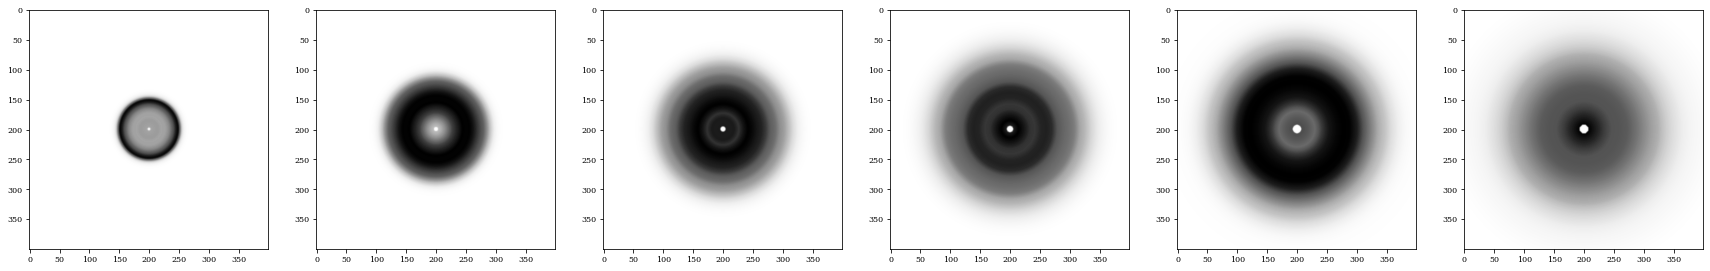

In [42]:
f,ax = plt.subplots(1,6,figsize = (30,5))
for a,loc in zip(ax,['6.0','6.1','6.2','6.3','6.4','6.5']):
    a.imshow(simulated_spots[loc],cmap = 'Greys', interpolation = 'bicubic')

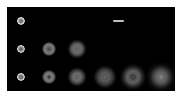

In [43]:
#now we plot everything together!
f,ax = plt.subplots(1,1,figsize = (3,11.5))

ALL_PLOTS = np.zeros((L*3,L*6))

ALL_PLOTS[:L,:L] = simulated_spots['1.0']

ALL_PLOTS[L:2*L,:L] = simulated_spots['3.0']
ALL_PLOTS[L:2*L,L:2*L] = simulated_spots['3.1']
ALL_PLOTS[L:2*L,2*L:3*L] = simulated_spots['3.2']

ALL_PLOTS[2*L:3*L,:L] = simulated_spots['6.0']
ALL_PLOTS[2*L:3*L,L:2*L] = simulated_spots['6.1']
ALL_PLOTS[2*L:3*L,2*L:3*L] = simulated_spots['6.2']
ALL_PLOTS[2*L:3*L,3*L:4*L] = simulated_spots['6.3']
ALL_PLOTS[2*L:3*L,4*L:5*L] = simulated_spots['6.4']
ALL_PLOTS[2*L:3*L,5*L:6*L] = simulated_spots['6.5']

plt.imshow(ALL_PLOTS,cmap = 'gray')
plt.axis('off')


ax.plot([3*L+L/2.+ 10*pixels_per_nm, 3*L+L/2.+ 20*pixels_per_nm],[L/2.,L/2],'w-')

plt.savefig('spots1.png',dpi=500)
plt.savefig('spots1.pdf')

In [44]:
#now we plot everything together!
ALL_PLOTS_big = np.zeros((L*4,L*24))

ALL_PLOTS_big[:L,:L] = simulated_spots['1.0']

ALL_PLOTS_big[L:2*L,:L] = simulated_spots['3.0']
ALL_PLOTS_big[L:2*L,L:2*L] = simulated_spots['3.1']
ALL_PLOTS_big[L:2*L,2*L:3*L] = simulated_spots['3.2']

ALL_PLOTS_big[2*L:3*L,:L] = simulated_spots['6.0']
ALL_PLOTS_big[2*L:3*L,L:2*L] = simulated_spots['6.1']
ALL_PLOTS_big[2*L:3*L,2*L:3*L] = simulated_spots['6.2']
ALL_PLOTS_big[2*L:3*L,3*L:4*L] = simulated_spots['6.3']
ALL_PLOTS_big[2*L:3*L,4*L:5*L] = simulated_spots['6.4']
ALL_PLOTS_big[2*L:3*L,5*L:6*L] = simulated_spots['6.5']

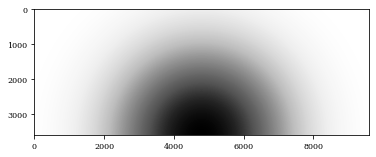

In [45]:
from astropy.convolution import AiryDisk2DKernel
a = AiryDisk2DKernel(400*pixels_per_nm,x_size = 24*L, 
                     y_size = 18*L).array[:9*L,:24*L]
a = a / np.sum(a) * 3e5
plt.imshow(a,cmap = 'Greys')

In [46]:
ALL_PLOTS2 = np.append(ALL_PLOTS_big,a,axis = 0)

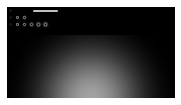

In [47]:
f,ax = plt.subplots(1,1,figsize = (3,3))

ax.imshow(ALL_PLOTS2,cmap = 'gray')

ax.axis('off')

ax.plot([3*L+L/2.+ 10*pixels_per_nm, 3*L+L/2.+ 110*pixels_per_nm],[L/2.,L/2],'w-')

plt.savefig('spots2.png',dpi=500)
plt.savefig('spots2.pdf',)

In [48]:
#airy disk now 

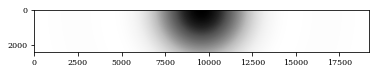

In [49]:
from astropy.convolution import AiryDisk2DKernel

a = AiryDisk2DKernel(400*pixels_per_nm,x_size = 48*L, 
                     y_size = 12*L).array[:6*L,:][::-1] #used to be 3...
a = a / np.sum(a) * 2e3
plt.imshow(a,cmap = 'Greys')

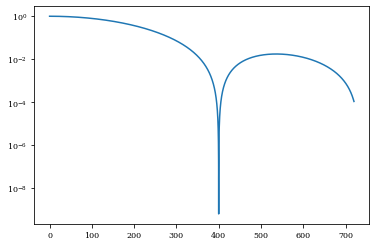

In [50]:

y0 = a[0][int(len(a[0])/2) : ]/np.max(a[0])
x0 = np.arange(len(y0))*(1/pixels_per_nm)
plt.plot(x0, y0)
plt.yscale('log')

In [51]:
def get_overlaps(sim):

    spot = sim[int(len(sim[index])/2):]
    plt.imshow(spot)

    overlaps = []   
    
    for overlap in range(0,len(a[1]) - len(spot[1])):
        section_of_a = a[:len(spot), overlap: len(spot[1])+overlap]
        overlaps.append(np.sum(spot * section_of_a))
        
    return overlaps[int(len(overlaps)/2):]/ np.max(overlaps)

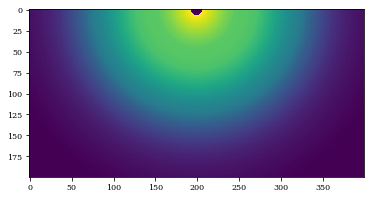

In [52]:
overlap_profiles = {}
for key in simulated_spots:
    overlap_profiles[key] = get_overlaps(simulated_spots[key])


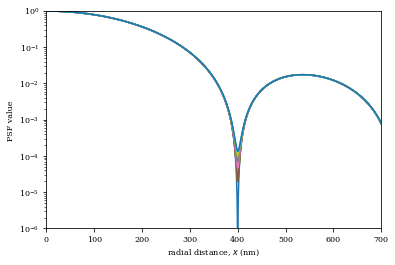

In [53]:
#need to get a value for x!

y0 = a[0][int(len(a[0])/2) : ]/np.max(a[0])
x0 = np.arange(len(y0))*(1/pixels_per_nm)
plt.plot(x0, y0)


for key in overlap_profiles:
    x1 = np.arange(len(overlap_profiles[key]))*(1/pixels_per_nm)
    plt.plot(x1,overlap_profiles[key])

plt.ylim(10**-6,10**0)
plt.xlim(0,700)
    
plt.ylabel('PSF value')
plt.xlabel('radial distance, $x$ (nm)')

plt.yscale('log')

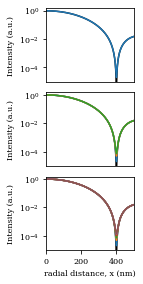

In [54]:
from matplotlib import rc
rc('font',**{'family':'serif','sans-serif':['Arial']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=False)
import matplotlib 
matplotlib.rc('xtick', labelsize=8) 
matplotlib.rc('ytick', labelsize=8) 
plt.rcParams.update({'font.size': 8})

jet = cm = plt.get_cmap('Dark2')    
cNorm = colors.Normalize(vmin=0,vmax=5)
scalarMap = cmx.ScalarMappable(norm=cNorm,cmap=jet)


f,ax = plt.subplots(3,1,figsize = (2,4),sharex=True)

y0 = a[0][int(len(a[0])/2) : ]/np.max(a[0])
x0 = np.arange(len(y0))*(1/pixels_per_nm)
for axi in ax:
    axi.plot(x0, y0,'k')


for index,key in enumerate(['1.0']):
    color = list(scalarMap.to_rgba(index))
    x1 = np.arange(len(overlap_profiles[key]))*(1/pixels_per_nm)
    ax[0].plot(x1,overlap_profiles[key])
for index,key in enumerate(['3.0','3.1','3.2']):
    x1 = np.arange(len(overlap_profiles[key]))*(1/pixels_per_nm)
    ax[1].plot(x1,overlap_profiles[key])
for index,key in enumerate(['6.0','6.1','6.2','6.3','6.4','6.5']):
    x1 = np.arange(len(overlap_profiles[key]))*(1/pixels_per_nm)
    ax[2].plot(x1,overlap_profiles[key])

    
for axi in ax[:2]:
    
    axi.tick_params(
                    axis='x',          # changes apply to the x-axis
                    which='both',      # both major and minor ticks are affected
                    bottom=False,      # ticks along the bottom edge are off
                    top=False,         # ticks along the top edge are off
                    labelbottom=False) # labels along the bottom edge are off

for axi in ax:
    axi.set_yscale('log')
    axi.set_ylabel('Intensity (a.u.)')
    axi.set_ylim(10**-5,1.5)
    axi.set_xlim(0,500)
    axi.set_yticks([10**-4,10**-2,10**0])
    
ax[2].set_xlabel('radial distance, x (nm)')
f.tight_layout()

plt.savefig('PDF.png',dpi = 1000)
plt.savefig('PSF.pdf',tight_layout=True)

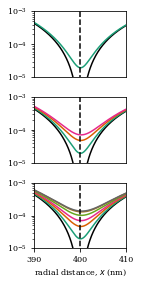

In [55]:

from matplotlib import rc
rc('font',**{'family':'serif','sans-serif':['Arial']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=False)
import matplotlib 
matplotlib.rc('xtick', labelsize=8) 
matplotlib.rc('ytick', labelsize=8) 
plt.rcParams.update({'font.size': 8})


jet = cm = plt.get_cmap('Dark2')    
cNorm = colors.Normalize(vmin=0,vmax=5)
scalarMap = cmx.ScalarMappable(norm=cNorm,cmap=jet)


f,ax = plt.subplots(3,1,figsize = (2,4))

y0 = a[0][int(len(a[0])/2) : ]/np.max(a[0])
x0 = np.arange(len(y0))*(1/pixels_per_nm)
for axi in ax:
    axi.plot(x0, y0,'k')


for index,key in enumerate(['1.0']):
    color = list(scalarMap.to_rgba(index))
    x1 = np.arange(len(overlap_profiles[key]))*(1/pixels_per_nm)
    ax[0].plot(x1,overlap_profiles[key],color  = color)
for index,key in enumerate(['3.0','3.1','3.2']):
    color = list(scalarMap.to_rgba(index))
    x1 = np.arange(len(overlap_profiles[key]))*(1/pixels_per_nm)
    ax[1].plot(x1,overlap_profiles[key],color  = color)
for index,key in enumerate(['6.0','6.1','6.2','6.3','6.4','6.5']):
    color = list(scalarMap.to_rgba(index))
    x1 = np.arange(len(overlap_profiles[key]))*(1/pixels_per_nm)
    ax[2].plot(x1,overlap_profiles[key],color  = color)
    
    
for axi in ax[:2]:
    
    axi.tick_params(
                    axis='x',          # changes apply to the x-axis
                    which='both',      # both major and minor ticks are affected
                    bottom=False,      # ticks along the bottom edge are off
                    top=False,         # ticks along the top edge are off
                    labelbottom=False) # labels along the bottom edge are off
    
for axi in ax:
    x_val = 400
    y_val = np.linspace(10**-8,10**-2)
    axi.plot(x_val*np.ones(len(y_val)),y_val,'k--')
    
for axi in ax:
    axi.set_yscale('log')
    #axi.set_ylabel('PSF value')
    axi.set_ylim(10**-5,0.2*10**-3)
    axi.set_xlim(390,410)
    axi.set_yticks([10**-5,10**-4,10**-3])
    
ax[2].set_xlabel('radial distance, $x$ (nm)')
f.tight_layout()
    

plt.savefig('closeupPDF.png',dpi = 1000)
plt.savefig('closeupPSF.pdf',tight_layout=True)

In [56]:

jet = cm = plt.get_cmap('Dark2')    
cNorm = colors.Normalize(vmin=0,vmax=5)
scalarMap = cmx.ScalarMappable(norm=cNorm,cmap=jet)

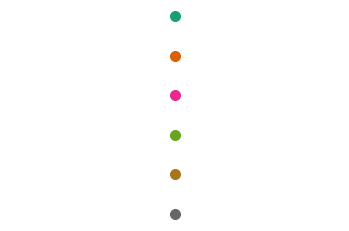

In [57]:

for index in range(6):
    color = scalarMap.to_rgba(index)
    plt.plot(1,-4*index,color = color,marker = 'o',markersize = 10)
    plt.axis('off')
plt.savefig('colorbar.png',dpi = 1000)
plt.savefig('colorbar.pdf',tight_layout = True)

In [58]:
overlap_profiles['0'] = (a[0][int(len(a[0])/2) : ]/np.max(a[0]))[:len(overlap_profiles['1.0'])] 

1.0 400.05
3.0 400.05
3.1 400.125
3.2 400.2
6.0 400.05
6.1 400.125
6.2 400.2
6.3 400.275
6.4 400.34999999999997
6.5 400.34999999999997
0 399.97499999999997


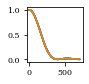

In [59]:
f,ax = plt.subplots(1,1,figsize = (1,1))

y0 = a[0][int(len(a[0])/2) : ]/np.max(a[0])
x0 = np.arange(len(y0))*(1/pixels_per_nm)
plt.plot(x0,y0)

for key in overlap_profiles:
    x1 = np.arange(len(overlap_profiles[key]))*(1/pixels_per_nm)
    plt.plot(x1,overlap_profiles[key])
    print (key,x1[np.argmin(overlap_profiles[key])])

In [60]:
import os

In [61]:
os.getcwd()

'/media/wtk23/Seagate Expansion Drive/Seagate/multi-paint/blur/observation'